In [1]:
# all required modules
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

# Part 1. Dataset and Unpruned Netowrk performance
## About Dataset
We're using KMNIST dataset, which consists of Japanese katakana characters of 10 different labels. This dataset surves as a more advanced and challenging version of popular MNIST dataset. The dataset is available in torchvision.datasets module. We're using the train and test splits of the dataset. The dataset is split into 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image, for a total of 784 pixels in each image. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [2]:
transform = transforms.Compose( [ transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,)) ] )
trainset = datasets.KMNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.KMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<Figure size 640x480 with 0 Axes>

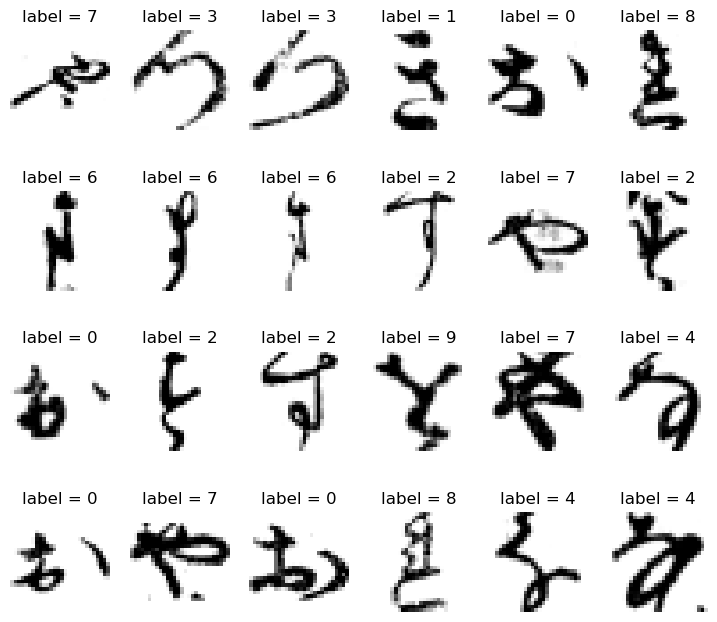

In [3]:
# Let's visualize some of images in our dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(torch.unique(labels))

figure = plt.figure()

num_row = 4
num_col = 6
num_of_images = num_row*num_col

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

for index in range(000, num_of_images):
    ax = axes[index//num_col, index%num_col]
    ax.set_title('label = {}'.format(labels[index].item()) )
    ax.axis('off')
    ax.imshow(images[index].numpy().squeeze(), cmap='gray_r')

plt.savefig('./data/dataset.png', dpi=140)
plt.show()

## Network architecture of choice
For the purposes of this study we will be using LeNet-5 architecture (LeCun et al. 1993)

In [4]:
from LeNet import LeNet, train_model
from LeNet import device

model = LeNet().to(device=device)

We would be using cross-entropy loss criterion and Adam optimizer with learning rate of 0.005.

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
loaders = {"train": trainloader, "valid": valloader}

Let's train unpruned network without regularization and see its performance

In [13]:
accuracy, time = train_model(model, optimizer, criterion, loaders, N_epochs = 50, display = True)
print('------------------------------------------------')
print('Training time : {:.2f} s'.format(time))
print('Accuracy : {}'.format(accuracy))

Epoch: 1
Loader: train. Accuracy: 0.8935833333333333
Loader: valid. Accuracy: 0.8702
Epoch: 2
Loader: train. Accuracy: 0.9639333333333333
Loader: valid. Accuracy: 0.8966
Epoch: 3
Loader: train. Accuracy: 0.9714333333333334
Loader: valid. Accuracy: 0.9165
Epoch: 4
Loader: train. Accuracy: 0.9756666666666667
Loader: valid. Accuracy: 0.9159
Epoch: 5
Loader: train. Accuracy: 0.9791833333333333
Loader: valid. Accuracy: 0.9298
Epoch: 6
Loader: train. Accuracy: 0.9814166666666667
Loader: valid. Accuracy: 0.9326
Epoch: 7
Loader: train. Accuracy: 0.9829333333333333
Loader: valid. Accuracy: 0.9243
Epoch: 8
Loader: train. Accuracy: 0.98415
Loader: valid. Accuracy: 0.9239
Epoch: 9
Loader: train. Accuracy: 0.9851166666666666
Loader: valid. Accuracy: 0.9305
Epoch: 10
Loader: train. Accuracy: 0.9859333333333333
Loader: valid. Accuracy: 0.9267
Epoch: 11
Loader: train. Accuracy: 0.9871333333333333
Loader: valid. Accuracy: 0.9229
Epoch: 12
Loader: train. Accuracy: 0.9877666666666667
Loader: valid. Accur

In [14]:
print('------------------------------------------------')
print('Training time : {:.2f} s'.format(time))
print('Accuracy : {}'.format(accuracy))

------------------------------------------------
Training time : 324.01 s
Accuracy : 0.9332


# Part 2. Weight regularization
Below is an example of appplying regularization function to loss and applying magnitude-based unstrusted pruning to Netowrk. Later the pruned Netowrk is being fine-tuned

In [ ]:
from weight_regularization import l1_s_norm

base_model = LeNet().to(device=device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr = 5e-3)
loaders = {"train": trainloader, "valid": valloader}

_, t_1 = train_model(base_model, optimizer, criterion, loaders, N_epochs = 10, reg = l1_s_norm)

In [ ]:
import torch.nn.utils.prune as prune
import copy

amounts = [99.7, 99.6, 99.5, 99.25, 99, 98.5, 98, 97, 95, 90, 80, 70]

train_time = []
acc = []

for amount in amounts:

    model = copy.deepcopy(base_model)
    model = copy.deepcopy(base_model)

    optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
    criterion = torch.nn.CrossEntropyLoss()

    parameters = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight')
              )

    prune.global_unstructured(
        parameters,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    accuracy, t_2 = train_model(model, optimizer, criterion, loaders, N_epochs=40)

    print('Amount : {} %, Valid accuracy : {:.5f}, time {:.1f} s'.format(
        amount * 100, accuracy, t_1+t_2) )

    acc.append(accuracy)
    train_time.append(t_1 + t_2)

### Plots
All the data is stored in "./data/structed_pruning.json". Here we plot accuracy from number of parameters for pruned networks obtained with different regularization functions

In [5]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

47854


In [99]:
import json

del data

with open("./data/structed_pruning.json", "r") as read_file:
    data = json.load(read_file)

In [100]:
import numpy as np

wr = data["weight_regularization"]

l1_param = np.round((100-np.array(wr["l1"]["amount, %"])) / 100 * total_params) * 2
l1_acc = np.array(wr["l1"]["mean_accuracy"])*100
l1_acc_err = np.array(wr["l1"]["std_accuracy"])*100

l1_s_param = np.round((100-np.array(wr["l1_s"]["amount, %"])) / 100 * total_params) * 2
l1_s_acc = np.array(wr["l1_s"]["mean_accuracy"])*100
l1_s_acc_err = np.array(wr["l1_s"]["std_accuracy"])*100

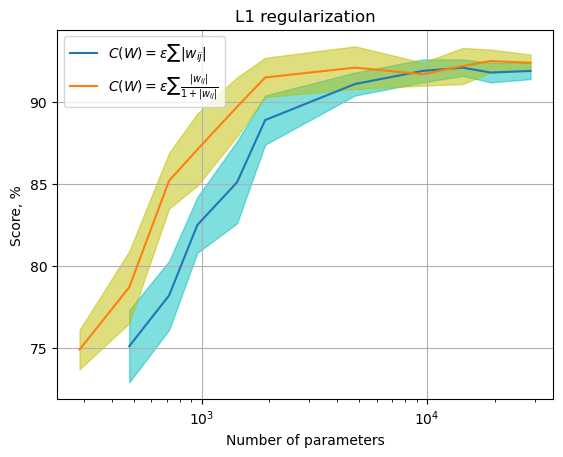

"'\nplt.fill_between(l1_param, l1_acc+l1_acc_err,\n                l1_acc-l1_acc_err, alpha=0.5, color ='c')\nplt.plot(l1_param, l1_acc, label=r'$C(W) = \\epsilon \\sum w_{ij}^2$')\nplt.fill_between(l1_s_param, l1_s_acc+l1_s_acc_err,\n                l1_s_acc-l1_s_acc_err, alpha=0.5, color ='y')\nplt.title('L2 regularization')\nplt.plot(l1_s_param, l1_s_acc, label=r'$C(W) = \\epsilon \\sum \x0crac{w_{ij}^2}{1+w_{ij}^2}$')\nplt.grid()\nplt.xlabel('Number of parameters')\nplt.ylabel('Score, %')\nplt.legend()\nplt.xscale('log')\nplt.show()\n"

In [111]:
plt.fill_between(l1_param, l1_acc+l1_acc_err,
                l1_acc-l1_acc_err, alpha=0.5, color ='c')
plt.plot(l1_param, l1_acc, label=r'$C(W) = \epsilon \sum |w_{ij}|$')
plt.fill_between(l1_s_param, l1_s_acc+l1_s_acc_err,
                l1_s_acc-l1_s_acc_err, alpha=0.5, color ='y')
plt.title('L1 regularization')
plt.plot(l1_s_param, l1_s_acc, label=r'$C(W) = \epsilon \sum \frac{|w_{ij}|}{1+|w_{ij}|}$')
plt.grid()
plt.xlabel('Number of parameters')
plt.ylabel('Score, %')
plt.legend()
plt.xscale('log')
plt.show()
''''
plt.fill_between(l1_param, l1_acc+l1_acc_err,
                l1_acc-l1_acc_err, alpha=0.5, color ='c')
plt.plot(l1_param, l1_acc, label=r'$C(W) = \epsilon \sum w_{ij}^2$')
plt.fill_between(l1_s_param, l1_s_acc+l1_s_acc_err,
                l1_s_acc-l1_s_acc_err, alpha=0.5, color ='y')
plt.title('L2 regularization')
plt.plot(l1_s_param, l1_s_acc, label=r'$C(W) = \epsilon \sum \frac{w_{ij}^2}{1+w_{ij}^2}$')
plt.grid()
plt.xlabel('Number of parameters')
plt.ylabel('Score, %')
plt.legend()
plt.xscale('log')
plt.show()
'''